<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.883 · Aprendizaje por refuerzo</p>
<p style="margin: 0; text-align:right;">Máster universitario en Ciencia de datos (<i>Data science</i>)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# PRA1: Deep Reinforcement Learning

#### AUTOR: Mario Ubierna San Mamés
 

En esta práctica se hará un estudio sobre el entorno **highway-env**, donde inicialmente se realizará una exploración sobre el entorno, posteriormente implementaremos un agente DQN y finalmente mejoraremos el primer agente implementado

## 0. Contexto

**Highway-env** es un problema de conducción autónoma, donde tenemos múltiples carriles y varios coches transitando. Nuestro objetivo es que el agente sea capaz de controlar el vehículo con el fin de:

- Evitar colisiones con otros vehículos.
- Tener la máxima velocidad posible.
- Mantenerse en el carril derecho lo más posible.

El entorno se considera superado cuando en el tiempo de observación máximo establecido, se han verificado las tres condiciones anteriores.

![Alt Text](https://raw.githubusercontent.com/eleurent/highway-env/gh-media/docs/media/highway-env.gif?raw=true)

## 1. Entorno

Lo primero de todo es cargar las librerías necesarias:

In [2]:
import gym
import highway_env
from collections import namedtuple, deque
from copy import deepcopy, copy
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import numpy as np
import time

<div style="background-color: #grey; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 1.1 (0.5 ptos) - </strong> Exploración del entorno y representación de una ejecución aleatoria:
</div>

#### Exploración del entorno

Carga del entorno:

In [3]:
# Definimos el entorno
env = gym.make("highway-v0")

Información básica del entorno:

In [4]:
print("El espacio de acciones es {} ".format(env.action_space))
print("La dimensión del espacio de acciones es: {}".format(env.action_space.n))
# print("Las acciones por defecto son {}".format(str(env.action_type.actions_indexes)))
print("El espacio de observaciones es {} ".format(env.observation_space))
print("La dimensión del espacio de estados: {}".format(env.observation_space.shape[0]))
print("El rango de recompensas es {} ".format(env.reward_range))

El espacio de acciones es Discrete(5) 
La dimensión del espacio de acciones es: 5
El espacio de observaciones es Box([[-inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf]], [[inf inf inf inf inf]
 [inf inf inf inf inf]
 [inf inf inf inf inf]
 [inf inf inf inf inf]
 [inf inf inf inf inf]], (5, 5), float32) 
La dimensión del espacio de estados: 5
El rango de recompensas es (-inf, inf) 


De la anterior ejecución podemos observar que, por defecto tanto la dimensión del espacio de acciones como de estados es 5. Estos valores vienen predefinidos a la hora de cargar el entorno **highway-v0**.  
  
Para saber más sobre la configuración por defecto del entorno ejecutamos la siguiente instrucción:

In [5]:
env.env.default_config()

{'observation': {'type': 'Kinematics'},
 'action': {'type': 'DiscreteMetaAction'},
 'simulation_frequency': 15,
 'policy_frequency': 1,
 'other_vehicles_type': 'highway_env.vehicle.behavior.IDMVehicle',
 'screen_width': 600,
 'screen_height': 150,
 'centering_position': [0.3, 0.5],
 'scaling': 5.5,
 'show_trajectories': False,
 'render_agent': True,
 'offscreen_rendering': False,
 'manual_control': False,
 'real_time_rendering': False,
 'lanes_count': 4,
 'vehicles_count': 50,
 'controlled_vehicles': 1,
 'initial_lane_id': None,
 'duration': 40,
 'ego_spacing': 2,
 'vehicles_density': 1,
 'collision_reward': -1,
 'right_lane_reward': 0.1,
 'high_speed_reward': 0.4,
 'lane_change_reward': 0,
 'reward_speed_range': [20, 30],
 'offroad_terminal': False}

Como podemos ver obtenemos la siguiente información:  
- El tipo de observación es Kinematics, esto lo que significa es que el espacio de estados va a ser una matriz del tipo VxF, donde V es el número de vehículos cercanos a nuestro coche y F el número de características (['presence', 'x', 'y', 'vx', 'vy']).

- El tipo de acciones es DiscreteMetaAction, en este caso hay 5 acciones. La primera es movernos al carril de la izquierda "0", la segunda es un movimiento ilegal o mantenernos en el carril actual a la velocidad actual "1" (cuando se produce un cambio de carril en el límite de la carretera, o cuando la acelaración o desaceleración es mayor o menor que la velocidad máxima/mínima) "1", la tercera es movernos al carril de la derecha "2", la cuarta es aumentar la velocidad "3" y la quinta reducir la velocidad "4".

- El número de carriles es 4, se puede modificar para añadir más o menos.

- El número de vehículos es 50 y al igual que antes se puede modificar.

- La recompensa por colisión es -1.

- La recompensa por estar en el carril de la derecha es 0.1.

- La recompensa por alcanzar una alta velocidad es 0.4.

- La recompensa por cambiar de carril es 0.

- Y la recompensa por aumentar o disminuir la velocidad varía entre 20 y 30 dependiendo de forma lineal a su velocidad.

A continuación podemos ver un ejemplo de una acción tomada aleatoriamente y todas las posibles acciones que podemos tomar:

In [6]:
print("Acción aleatoria tomada {}".format(env.action_space.sample()))
print("Las posibles acciones son {}".format(env.action_type.actions_indexes))

Acción aleatoria tomada 2
Las posibles acciones son {'LANE_LEFT': 0, 'IDLE': 1, 'LANE_RIGHT': 2, 'FASTER': 3, 'SLOWER': 4}


Para concluir con la exploración del entorno, vamos a mostrar un ejemplo de un estado según el espacio de observaciones por defecto junto el nombre de cada columna:

In [7]:
print("Un estado aleatorio sería \n{}".format(env.observation_space.sample()))
print("El nombre de cada columna (característica \"F\") es {}".format(env.env.observation_type.features))

Un estado aleatorio sería 
[[ 0.47789434  0.14970075 -0.95439225 -0.5071257  -0.5717195 ]
 [-1.7145699  -1.08008     1.5356616   0.01742784 -0.14317273]
 [-0.4287193   1.2831037   0.85987455  0.6341575  -0.08645776]
 [ 0.72056687 -0.04689763 -0.17241746  0.10433157  0.9343766 ]
 [ 1.0721375  -0.36556318 -0.74792737 -1.3635495  -0.7361571 ]]
El nombre de cada columna (característica "F") es ['presence', 'x', 'y', 'vx', 'vy']


#### Representación de una ejecución aleatoria

Obs inicial:


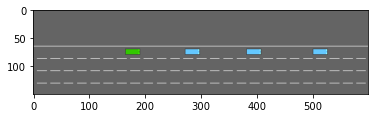

[[ 1.          0.91424745  0.          0.3125      0.        ]
 [ 1.          0.09642161  0.         -0.03039612  0.        ]
 [ 1.          0.19671127  0.         -0.02337849  0.        ]
 [ 1.          0.3051578   0.         -0.04828252  0.        ]
 [ 1.          0.41003048  0.25       -0.01353156  0.        ]]

Acción: LANE_RIGHT -> recommpensa: 0.8222222222222223
Nuevo estado:


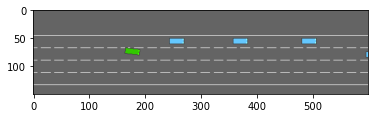

[[ 1.          1.          0.20821731  0.31063917  0.03405233]
 [ 1.          0.07142314 -0.20821731 -0.10351981 -0.03405233]
 [ 1.          0.17468563 -0.20821731 -0.09077308 -0.03405233]
 [ 1.          0.28658983 -0.20821731 -0.04845467 -0.03405233]
 [ 1.          0.39173892  0.05708825 -0.08667212 -0.03484139]]

Acción: SLOWER -> recommpensa: 0.7116739868390409
Nuevo estado:


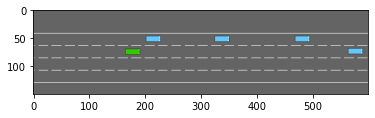

[[ 1.0000000e+00  1.0000000e+00  2.6070890e-01  2.6068038e-01
   2.6056790e-04]
 [ 1.0000000e+00  3.3068102e-02 -2.6070890e-01 -9.2326351e-02
  -2.6056790e-04]
 [ 1.0000000e+00  1.4542851e-01 -2.6070890e-01 -6.2157676e-02
  -2.6056790e-04]
 [ 1.0000000e+00  2.7588511e-01 -2.6070890e-01 -1.5201254e-02
  -2.6056790e-04]
 [ 1.0000000e+00  3.6226505e-01 -8.3880853e-03 -5.1026840e-02
  -2.2357439e-03]]

Acción: LANE_LEFT -> recommpensa: 0.0
Nuevo estado:


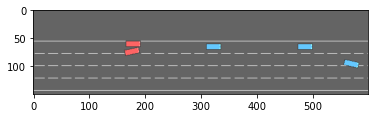

[[ 1.0000000e+00  1.0000000e+00  9.9087849e-02  1.5361723e-01
  -3.1473875e-02]
 [ 1.0000000e+00  7.9695828e-04 -1.5508990e-01 -5.4045837e-02
   3.1473875e-02]
 [ 1.0000000e+00  1.3150257e-01 -9.9087849e-02  4.0373322e-02
   3.1473875e-02]
 [ 1.0000000e+00  2.8039789e-01 -9.9087849e-02  8.5128158e-02
   3.1473875e-02]
 [ 1.0000000e+00  3.5626110e-01  2.5441664e-01  6.6620506e-02
   8.0655940e-02]]
Episodio terminado después de 3 pasos y la recompensa fue 1.5338962090612633


In [11]:
obs = env.reset()
t, total_reward, done = 0, 0, False

print("Obs inicial:")
plt.imshow(env.render(mode="rgb_array"))
plt.show()
print(obs)

while not done:
    # Obtener la acción y la ejecutamos
    action = env.action_space.sample()
    new_obs, reward, done, info = env.step(action)
    
    # Imprimimos el paso
    print("\nAcción: {} -> recommpensa: {}".format(env.action_type.actions[action], reward))
    print("Nuevo estado:")
    plt.imshow(env.render(mode="rgb_array"))
    plt.show()
    env.close()
    print(new_obs)
    
    t += 1
    total_reward += reward
    obs = new_obs
    
print("Episodio terminado después de {} pasos y la recompensa fue {}".format(t, total_reward))

<div style="background-color: #grey; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 1.2 (0.5 ptos) - </strong> Explicar los diferentes espacios de observaciones y de acciones:
</div>

Resuelto en el informe

## 2. Agente de referencia

<div style="background-color: #grey; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 2.1 (1.5 ptos) - </strong> Implementar un agente DQN con la observación kinematics
</div>

Lo primero de todo es definir la clase que nos va a permitir crear el replay buffer:

In [12]:
class experienceReplayBuffer:

    def __init__(self, memory_size=50000, burn_in=10000):
        self.memory_size = memory_size
        self.burn_in = burn_in
        self.buffer = namedtuple('Buffer', 
            field_names=['state', 'action', 'reward', 'done', 'next_state'])
        self.replay_memory = deque(maxlen=memory_size)

    def sample_batch(self, batch_size=32):
        samples = np.random.choice(len(self.replay_memory), batch_size, 
                                   replace=False)
        # Use asterisk operator to unpack deque 
        batch = zip(*[self.replay_memory[i] for i in samples])
        return batch

    def append(self, state, action, reward, done, next_state):
        self.replay_memory.append(
            self.buffer(state, action, reward, done, next_state))

    def burn_in_capacity(self):
        return len(self.replay_memory) / self.burn_in

Posteriormente tenemos que crear la red neuronal:

In [36]:
class NeuralNet(torch.nn.Module):  

    def __init__(self, env, learning_rate=1e-3):
        
        """
        Params
        ======
        n_inputs: tamaño del espacio de estadps
        n_outputs: tamaño del espacio de acciones
        actions: array de acciones posibles
        """
        ######################################
        ##TODO: Inicializar parámetros
        super(NeuralNet, self).__init__()
        self.n_inputs = env.observation_space.shape[0]
        self.n_outputs = env.action_space.n
        self.actions = np.arange(env.action_space.n)
        self.learning_rate = learning_rate
        
        #######################################
        ##TODO: Neural network
        self.model = torch.nn.Sequential(
            torch.nn.Linear(self.n_inputs, 512, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 256, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(128, self.n_outputs, bias=True),
        )
        
        #######################################
        ##TODO: Initialize optimizer
        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)


    ### e-greedy method
    def get_action(self, state, epsilon=0.05):
        if np.random.random() < epsilon:
            action = np.random.choice(self.actions)  # acción random
        else:
            qvals = self.get_qvals(state)  # acción del cálculo de Q para esta acción
#             print(state)
#             print(qvals)
#             print(state[0])
#             print(self.get_qvals(state[0]))
#             action= torch.max(qvals, dim=-1)[1].item()
            action= torch.max(qvals[0], dim=-1)[1].item()
#             print(action)
        return action
    
    
    def get_qvals(self, state):
        if type(state) is tuple:
#             print("*******************")
#             print("ACTUALIZCION")
#             print(state)
#             state = np.array([np.ravel(s) for s in state])
#             print(state)
#             print("*******************")
            lista = []
            for s in state:
                lista.append(s[0])
            state = np.array(lista)
        state_t = torch.FloatTensor(state)
        return self.model(state_t)  

Luego tenemos que crear el agente:

In [37]:
class DQNAgent:
    
    ######################################
    ##TODO 1: Declarar variables
    def __init__(self, env, main_network, buffer, epsilon=0.1, eps_decay=0.99, batch_size=32):
        
        self.env = env
        self.main_network = main_network
        self.target_network = deepcopy(main_network) 
        self.buffer = buffer
        self.epsilon = epsilon
        self.eps_decay = eps_decay
        self.batch_size = batch_size
        self.nblock = 100 # bloque de los X últimos episodios de los que se calculará la media de recompensas
        self.initialize()
        
    ######################################
    ##TODO 2: Inicializar otras variables necesarias
    def initialize(self):
        self.update_loss = []
        self.training_rewards = []
        self.mean_training_rewards = []
        self.history_loss = []
        self.update_epsilon = []
        self.sync_eps = []
        self.total_reward = 0
        self.step_count = 0
        self.state0 = self.env.reset()
    
    ######################################
    ##TODO 3: Tomar paso siguiente
    def take_step(self, eps, mode='train'):
        if mode == 'explore': 
            action = self.env.action_space.sample()  # acción aleatoria en el burn-in
        else:
            action = self.main_network.get_action(self.state0, eps) # acción a partir del valor de Q (elección de la acción con mejor Q)
            self.step_count += 1
            
        #TODO: tomar 'step' i obtener nuevo estado y recompensa. Guardar la experiencia en el buffer
        new_state, reward, done, _ = self.env.step(action)
        self.total_reward += reward
        self.buffer.append(self.state0, action, reward, done, new_state)
        self.state0 = new_state.copy()
        
        #TODO: resetear entorno 'if done'
        if done:
            self.state0 = self.env.reset()
        return done

    ## TRAINING
    def train(self, gamma=0.99, max_episodes=50000, 
              batch_size=32,
              dnn_update_frequency=4,
              dnn_sync_frequency=2000):
        
        self.gamma = gamma

        # Rellenamos el buffer con N experiencias aleatorias ()
        print("Filling replay buffer...")
        while self.buffer.burn_in_capacity() < 1:
            self.take_step(self.epsilon, mode='explore')

            
        episode = 0
        training = True
        print("Training...")
        while training:
            self.state0 = self.env.reset()
            self.total_reward = 0
            gamedone = False
            while gamedone == False:
                # El agente toma una acción
                gamedone = self.take_step(self.epsilon, mode='train')
                
                #################################################################################
                #####TODO 4:  Actualizar la red principal según la frecuencia establecida #######
                if self.step_count % dnn_update_frequency == 0:
                    self.update()
                    
                ########################################################################################
                ###TODO 6: Sincronizar red principal y red objetivo según la frecuencia establecida#####
                if self.step_count % dnn_sync_frequency == 0:
                    self.target_network.load_state_dict(
                        self.main_network.state_dict()
                    )
                    self.sync_eps.append(episode)
                
                if gamedone:                   
                    episode += 1
                    
                    # Guardamos la evolución de la pérdida
                    self.history_loss.append(np.mean(self.update_loss))
                        
                    self.update_loss = []
                                    
                    #######################################################################################
                    ###TODO 7: calcular la media de recompensa de los últimos X episodios, y almacenar
                    self.training_rewards.append(self.total_reward)
                    mean_rewards = np.mean(
                        self.training_rewards[-self.nblock:]
                    )
                    self.mean_training_rewards.append(mean_rewards)

                    self.update_epsilon.append(self.epsilon) # Guardamos la evolución de epsilon
                    
                    print("\rEpisode {:d} Mean Rewards {:.2f} Epsilon {}\t\t".format(
                        episode, mean_rewards, self.epsilon), end="")
                    
                    #######################################################################################
                    ### TODO 8: Comprobar que todavía quedan episodios. Parar el aprendizaje si se llega al límite
                    if episode >= max_episodes:
                        training = False
                        print('\nEpisode limit reached')
                        break
                    
                    #Termina el juego si la media de recompensas ha llegado al umbral fijado para este juego  
#                     if mean_rewards >= self.reward_threshold:
#                         training = False
#                         print('\nEnvironment solved in {} episodes!'.format(
#                             episode))
#                         break
                    
                    #################################################################################
                    ######TODO 9: Actualizar epsilon según la velocidad de decaimiento fijada########
                    self.epsilon = max(self.epsilon * self.eps_decay, 0.01)

                    
    #####################################         
    #####TODO 5: cálculo de la pérdida###
    def calculate_loss(self, batch):
        # Separamos las variables de la experiencia y las convertimos a tensores 
        states, actions, rewards, dones, next_states = [i for i in batch] 
        rewards_vals = torch.FloatTensor(rewards)
        actions_vals = torch.LongTensor(np.array(actions)).reshape(-1,1)
        dones_t = torch.ByteTensor(dones)
        
#         print(states)
#         print("*******************")
#         print(actions)
#         print("*******************")
#         print(actions_vals)
#         print("*******************")
#         aux1 = self.main_network.get_qvals(states) 
#         print(aux1)
        
        # Obtenemos los valores de Q de la red principal
        qvals = torch.gather(self.main_network.get_qvals(states), 1, actions_vals)
#         print(qvals)
        # Obtenemos los valores de Q objetivo. El parámetro detach() evita que estos valores actualicen la red objetivo
        qvals_next = torch.max(self.target_network.get_qvals(next_states),
                               dim=-1)[0].detach()
        qvals_next[dones_t] = 0 # 0 en estados terminales
        
        #################################################################################
        ### TODO: Calcular ecuación de Bellman
        expected_qvals = self.gamma * qvals_next + rewards_vals
        
        #################################################################################
        ### TODO: Calcular la pérdida (MSE)
        loss = torch.nn.MSELoss()(qvals, expected_qvals.reshape(-1,1))
        
        return loss

    
    def update(self):
        self.main_network.optimizer.zero_grad()  # eliminamos cualquier gradiente pasado
        batch = self.buffer.sample_batch(batch_size=self.batch_size) # seleccionamos un conjunto del buffer
        loss = self.calculate_loss(batch) # calculamos la pérdida
        loss.backward() # hacemos la diferencia para obtener los gradientes
        self.main_network.optimizer.step() # aplicamos los gradientes a la red neuronal
        # Guardamos los valores de pérdida
        self.update_loss.append(loss.detach().numpy())
        
    def plot_rewards(self):
        plt.figure(figsize=(12,8))
        plt.plot(self.training_rewards, label='Rewards')
        plt.plot(self.mean_training_rewards, label='Mean Rewards')
        plt.title("Evolución de las recompensas")
        plt.xlabel('Episode')
        plt.ylabel('Reward')
        plt.legend(loc="upper left")
        plt.show()
        
    def plot_loss(self):
        plt.figure(figsize=(12,8))
        plt.plot(self.history_loss)
        plt.title("Evolución de la pérdida")
        plt.xlabel('Episode')
        plt.ylabel('Loss')
        plt.show()
        
    def plot_epsilon(self):
        plt.figure(figsize=(12,8))
        plt.plot(self.update_epsilon)
        plt.title("Evolución de epsilon")
        plt.xlabel('Episode')
        plt.ylabel('Epsilon')
        plt.show()

<div style="background-color: #grey; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 2.2 (1 ptos) - </strong> Entrenar el agente y buscar los hiperparámetros óptimos:
</div>

In [47]:
# Definición de los hiperparámetros
lr = 0.001            # Velocidad de aprendizaje
BATCH_SIZE = 32       # Tamaño del batch
MAX_EPISODES = 1500   # Número de episodios
BURN_IN = 100        # Número de episodios para rellenar el buffer
DNN_UPD = 3           # Frecuencia de actualización de la red neuronal
DNN_SYNC = 1000       # Frecuencia de sincronización con la red objetivo
MEMORY_SIZE = 10000   # Capacidad máxima del buffer
GAMMA = 0.99          # Factor de descuento
EPSILON = 1           # Epsilon
EPSILON_DECAY = 0.99   # Decaimiento de epsilon
# lr = 0.001            # Velocidad de aprendizaje
# BATCH_SIZE = 32       # Tamaño del batch
# MAX_EPISODES = 5000   # Número de episodios
# BURN_IN = 1        # Número de episodios para rellenar el buffer
# DNN_UPD = 3           # Frecuencia de actualización de la red neuronal
# DNN_SYNC = 1000       # Frecuencia de sincronización con la red objetivo
# MEMORY_SIZE = 10   # Capacidad máxima del buffer
# GAMMA = 0.99          # Factor de descuento
# EPSILON = 0.01           # Epsilon
# EPSILON_DECAY = 0.99   # Decaimiento de epsilon

In [46]:
# Carga de la red neuronal
dqn = NeuralNet(env, learning_rate=lr)

# Creación del buffer
buffer = experienceReplayBuffer(
    memory_size=MEMORY_SIZE, 
    burn_in=BURN_IN
)

# Creación del agente
agent_dqn = DQNAgent(
    env=env,
    main_network=dqn,
    buffer=buffer,
    epsilon=EPSILON,
    eps_decay=EPSILON_DECAY,
    batch_size=BATCH_SIZE
)

# Entrenamos el agente
agent_dqn.train(
    gamma=GAMMA, 
    max_episodes=MAX_EPISODES, 
    batch_size=BATCH_SIZE,  
    dnn_update_frequency=DNN_UPD, 
    dnn_sync_frequency=DNN_SYNC
)

Filling replay buffer...


KeyboardInterrupt: 

In [43]:
# Guardamos el modelo entrenado
trained_model = {
    "state_dic" : agent_dqn.main_network.state_dict()
}
torch.save(trained_model, "DQN.pth")

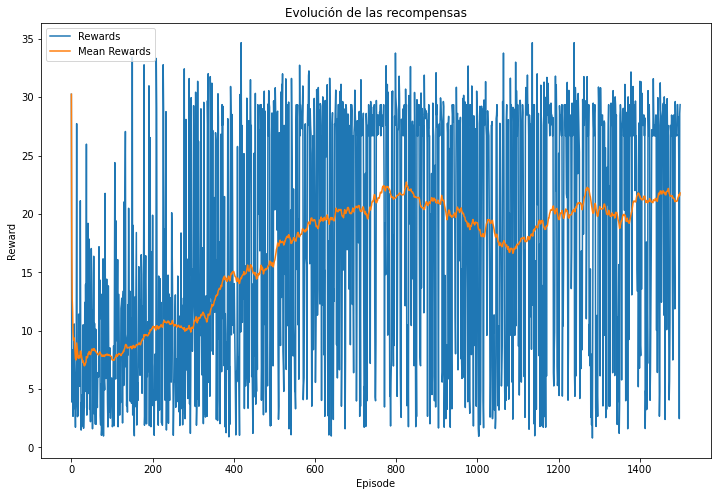

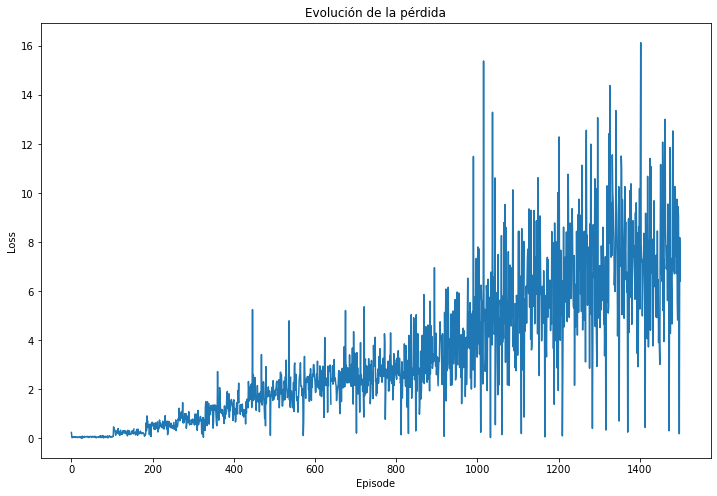

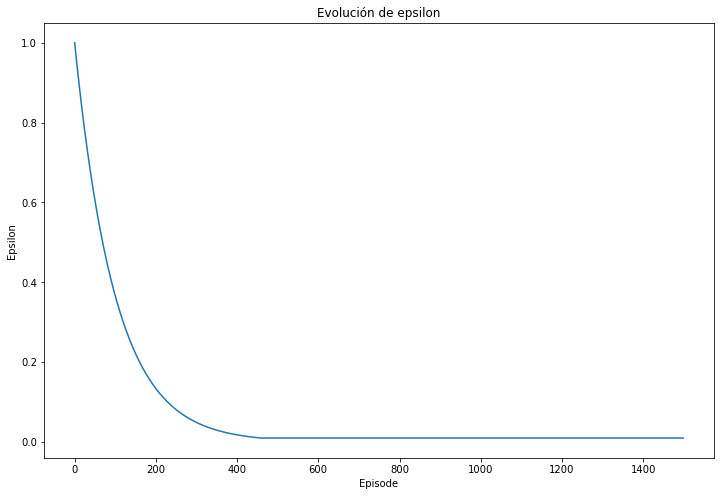

In [44]:
agent_dqn.plot_rewards()
agent_dqn.plot_loss()
agent_dqn.plot_epsilon()

Obs inicial:


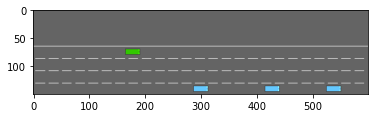

[[ 1.          0.91708165  0.          0.3125      0.        ]
 [ 1.          0.11026534  0.75       -0.04587903  0.        ]
 [ 1.          0.22695221  0.75       -0.0222161   0.        ]
 [ 1.          0.3270896   0.75       -0.01865065  0.        ]
 [ 1.          0.43005168  0.         -0.03594514  0.        ]]

Acción: SLOWER -> recommpensa: 0.6894517646168187
Nuevo estado:


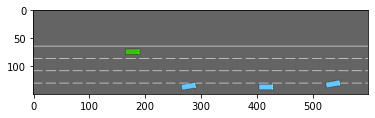

[[ 1.          1.          0.          0.26068053  0.        ]
 [ 1.          0.09180906  0.7113157  -0.05576154 -0.03370723]
 [ 1.          0.21679626  0.71749735 -0.03795581 -0.00373145]
 [ 1.          0.32716838  0.6698811   0.00717376 -0.04744608]
 [ 1.          0.42814288  0.          0.01538063  0.        ]]

Acción: SLOWER -> recommpensa: 0.6705603718311518
Nuevo estado:


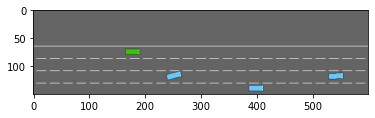

[[ 1.          1.          0.          0.25182518  0.        ]
 [ 1.          0.06768271  0.4956814  -0.05283613 -0.05040287]
 [ 1.          0.20019045  0.74262625 -0.03427851  0.00486738]
 [ 1.          0.3315781   0.5020944   0.01492547 -0.01548101]
 [ 1.          0.43418905  0.          0.01275918  0.        ]]

Acción: SLOWER -> recommpensa: 0.6673320550683801
Nuevo estado:


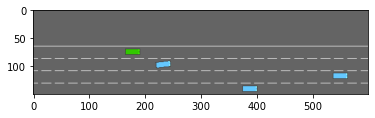

[[ 1.00000000e+00  1.00000000e+00  0.00000000e+00  2.50311911e-01
   0.00000000e+00]
 [ 1.00000000e+00  5.03417961e-02  2.63318956e-01 -2.90859398e-02
  -2.63517238e-02]
 [ 1.00000000e+00  1.90047860e-01  7.51374781e-01 -1.66699532e-02
   3.25380242e-04]
 [ 1.00000000e+00  3.37654263e-01  4.91558105e-01  1.45738255e-02
   2.11279490e-03]
 [ 1.00000000e+00  4.38420415e-01  0.00000000e+00  8.36016610e-03
   0.00000000e+00]]

Acción: SLOWER -> recommpensa: 0.6667803737159762
Nuevo estado:


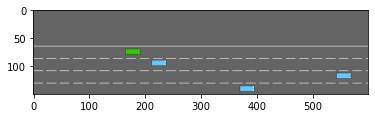

[[ 1.0000000e+00  1.0000000e+00  0.0000000e+00  2.5005329e-01
   0.0000000e+00]
 [ 1.0000000e+00  4.2103421e-02  2.3817658e-01 -1.3488854e-02
   1.8537214e-03]
 [ 1.0000000e+00  1.8561460e-01  7.5040084e-01 -5.6137894e-03
  -2.3036265e-04]
 [ 1.0000000e+00  3.4316075e-01  4.9975908e-01  1.2901139e-02
   8.0618472e-04]
 [ 1.0000000e+00  4.4119653e-01  0.0000000e+00  5.5876318e-03
   0.0000000e+00]]

Acción: SLOWER -> recommpensa: 0.6666860978635878
Nuevo estado:


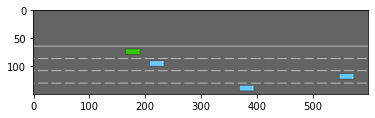

[[ 1.0000000e+00  1.0000000e+00  0.0000000e+00  2.5000912e-01
   0.0000000e+00]
 [ 1.0000000e+00  3.8469814e-02  2.4906087e-01 -4.8248661e-03
   1.3136193e-03]
 [ 1.0000000e+00  1.8476428e-01  7.4993944e-01  1.3692627e-03
  -1.9815456e-05]
 [ 1.0000000e+00  3.4775856e-01  5.0041252e-01  9.5981117e-03
  -9.0745583e-05]
 [ 1.0000000e+00  4.4311169e-01  0.0000000e+00  4.0412042e-03
   0.0000000e+00]]

Acción: SLOWER -> recommpensa: 0.6666699872296054
Nuevo estado:


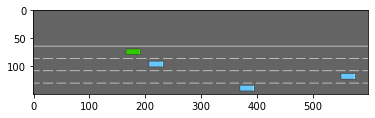

[[ 1.0000000e+00  1.0000000e+00  0.0000000e+00  2.5000155e-01
   0.0000000e+00]
 [ 1.0000000e+00  3.7583057e-02  2.5056604e-01  2.6436342e-04
  -6.7311928e-05]
 [ 1.0000000e+00  1.8626194e-01  7.4997884e-01  6.1260858e-03
   1.1083266e-05]
 [ 1.0000000e+00  3.5086492e-01  5.0001997e-01  5.6913467e-03
  -4.1303680e-05]
 [ 1.0000000e+00  4.4455671e-01  0.0000000e+00  3.2174008e-03
   0.0000000e+00]]

Acción: SLOWER -> recommpensa: 0.6666672341118053
Nuevo estado:


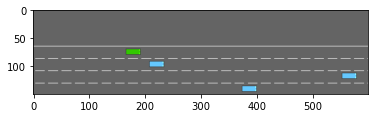

[[ 1.0000000e+00  1.0000000e+00  0.0000000e+00  2.5000027e-01
   0.0000000e+00]
 [ 1.0000000e+00  3.8284719e-02  2.5005764e-01  3.1648315e-03
  -6.5677879e-05]
 [ 1.0000000e+00  1.8934532e-01  7.5000268e-01  9.2750061e-03
   1.1571148e-06]
 [ 1.0000000e+00  3.5246256e-01  4.9998057e-01  2.1499952e-03
   3.4978168e-06]
 [ 1.0000000e+00  4.4575581e-01  0.0000000e+00  2.7996867e-03
   0.0000000e+00]]

Acción: SLOWER -> recommpensa: 0.6666667636363646
Nuevo estado:


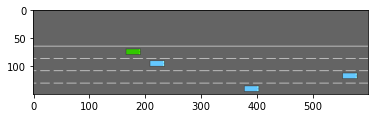

[[ 1.00000000e+00  1.00000000e+00  0.00000000e+00  2.50000060e-01
   0.00000000e+00]
 [ 1.00000000e+00  3.98875698e-02  2.49973193e-01  4.80215019e-03
   2.11408519e-06]
 [ 1.00000000e+00  1.93460107e-01  7.50001073e-01  1.12738665e-02
  -5.35381560e-07]
 [ 1.00000000e+00  3.52748930e-01  4.99998599e-01 -8.19300651e-04
   2.06800496e-06]
 [ 1.00000000e+00  4.46834743e-01  0.00000000e+00  2.61019426e-03
   0.00000000e+00]]

Acción: SLOWER -> recommpensa: 0.6666666832376471
Nuevo estado:


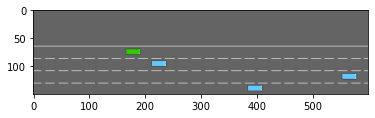

[[ 1.0000000e+00  1.0000000e+00  0.0000000e+00  2.5000000e-01
   0.0000000e+00]
 [ 1.0000000e+00  4.1995846e-02  2.4999666e-01  5.7100896e-03
   3.2668843e-06]
 [ 1.0000000e+00  1.9821596e-01  7.4999988e-01  1.2500470e-02
  -6.5923366e-08]
 [ 1.0000000e+00  3.5195255e-01  5.0000089e-01 -3.2625175e-03
  -1.1730880e-07]
 [ 1.0000000e+00  4.4786450e-01  0.0000000e+00  2.5509265e-03
   0.0000000e+00]]

Acción: SLOWER -> recommpensa: 0.6666666694984523
Nuevo estado:


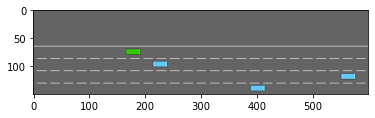

[[ 1.0000000e+00  1.0000000e+00  0.0000000e+00  2.5000000e-01
   0.0000000e+00]
 [ 1.0000000e+00  4.4382740e-02  2.5000125e-01  6.2084584e-03
  -4.3927059e-08]
 [ 1.0000000e+00  2.0330723e-01  7.4999994e-01  1.2667116e-02
   2.5743210e-08]
 [ 1.0000000e+00  3.5022697e-01  5.0000006e-01 -5.3889644e-03
  -1.0136186e-07]
 [ 1.0000000e+00  4.4888610e-01  0.0000000e+00  2.5676561e-03
   0.0000000e+00]]

Acción: SLOWER -> recommpensa: 0.6666666671505856
Nuevo estado:


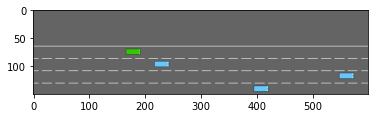

[[ 1.0000000e+00  1.0000000e+00  0.0000000e+00  2.5000000e-01
   0.0000000e+00]
 [ 1.0000000e+00  4.6923056e-02  2.5000018e-01  6.4855064e-03
  -1.6142998e-07]
 [ 1.0000000e+00  2.0821641e-01  7.5000000e-01  1.1726866e-02
   3.6968768e-09]
 [ 1.0000000e+00  3.4795529e-01  4.9999997e-01 -5.6760958e-03
   2.9530165e-09]
 [ 1.0000000e+00  4.4992363e-01  0.0000000e+00  2.6300077e-03
   0.0000000e+00]]

Acción: SLOWER -> recommpensa: 0.6666666667493626
Nuevo estado:


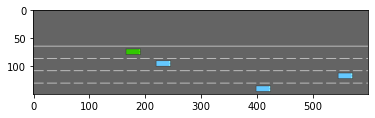

[[ 1.0000000e+00  1.0000000e+00  0.0000000e+00  2.5000000e-01
   0.0000000e+00]
 [ 1.0000000e+00  4.9549993e-02  2.4999994e-01  6.6464175e-03
  -8.1736595e-10]
 [ 1.0000000e+00  2.1268287e-01  7.5000000e-01  1.0512322e-02
  -1.2139532e-09]
 [ 1.0000000e+00  3.4584838e-01  5.0000000e-01 -4.6555558e-03
   4.9002487e-09]
 [ 1.0000000e+00  4.5099181e-01  0.0000000e+00  2.7206773e-03
   0.0000000e+00]]

Acción: SLOWER -> recommpensa: 0.6666666666807984
Nuevo estado:


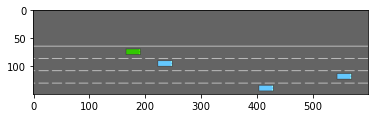

[[ 1.0000000e+00  1.0000000e+00  0.0000000e+00  2.5000000e-01
   0.0000000e+00]
 [ 1.0000000e+00  5.2228864e-02  2.4999999e-01  6.7478963e-03
   7.9229192e-09]
 [ 1.0000000e+00  2.1666171e-01  7.5000000e-01  9.3163718e-03
  -2.0422630e-10]
 [ 1.0000000e+00  3.4426156e-01  5.0000000e-01 -3.1394460e-03
  -2.8567371e-11]
 [ 1.0000000e+00  4.5209992e-01  0.0000000e+00  2.8295843e-03
   0.0000000e+00]]

Acción: SLOWER -> recommpensa: 0.6666666666690816
Nuevo estado:


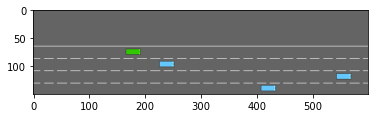

[[ 1.0000000e+00  1.0000000e+00  0.0000000e+00  2.5000000e-01
   0.0000000e+00]
 [ 1.0000000e+00  5.4942086e-02  2.5000000e-01  6.8196254e-03
   1.8630719e-10]
 [ 1.0000000e+00  2.2018144e-01  7.5000000e-01  8.2307616e-03
   5.6117111e-11]
 [ 1.0000000e+00  3.4330401e-01  5.0000000e-01 -1.5517056e-03
  -2.3673752e-10]
 [ 1.0000000e+00  4.5325404e-01  0.0000000e+00  2.9506749e-03
   0.0000000e+00]]

Acción: SLOWER -> recommpensa: 0.6666666666670794
Nuevo estado:


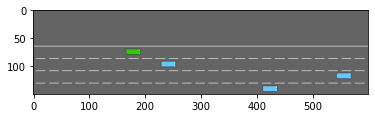

[[ 1.00000000e+00  1.00000000e+00  0.00000000e+00  2.50000000e-01
   0.00000000e+00]
 [ 1.00000000e+00  5.76809272e-02  2.50000000e-01  6.87672431e-03
  -3.86228272e-10]
 [ 1.00000000e+00  2.23290443e-01  7.50000000e-01  7.27047911e-03
   1.10886855e-11]
 [ 1.00000000e+00  3.42962801e-01  5.00000000e-01 -8.46360126e-05
  -3.63797881e-12]
 [ 1.00000000e+00  4.54458237e-01  0.00000000e+00  3.08016408e-03
   0.00000000e+00]]

Acción: SLOWER -> recommpensa: 0.6666666666667371
Nuevo estado:


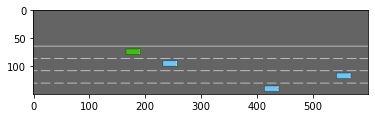

[[ 1.0000000e+00  1.0000000e+00  0.0000000e+00  2.5000000e-01
   0.0000000e+00]
 [ 1.0000000e+00  6.0441103e-02  2.5000000e-01  6.9266888e-03
  -1.6275314e-11]
 [ 1.0000000e+00  2.2603725e-01  7.5000000e-01  6.4248778e-03
  -2.5442981e-12]
 [ 1.0000000e+00  3.4317455e-01  5.0000000e-01  1.1965366e-03
   1.1418422e-11]
 [ 1.0000000e+00  4.5571542e-01  0.0000000e+00  3.2155653e-03
   0.0000000e+00]]

Acción: SLOWER -> recommpensa: 0.6666666666666786
Nuevo estado:


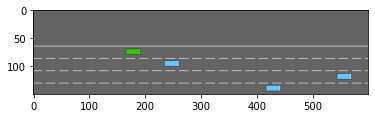

[[ 1.0000000e+00  1.0000000e+00  0.0000000e+00  2.5000000e-01
   0.0000000e+00]
 [ 1.0000000e+00  6.3220531e-02  2.5000000e-01  6.9731292e-03
   1.8699708e-11]
 [ 1.0000000e+00  2.2846474e-01  7.5000000e-01  5.6778402e-03
  -5.9241501e-13]
 [ 1.0000000e+00  3.4386304e-01  5.0000000e-01  2.2887366e-03
   4.0722981e-13]
 [ 1.0000000e+00  4.5702758e-01  0.0000000e+00  3.3551485e-03
   0.0000000e+00]]

Acción: SLOWER -> recommpensa: 0.6666666666666687
Nuevo estado:


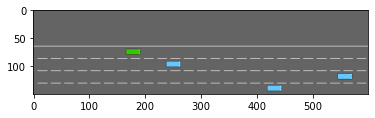

[[ 1.00000000e+00  1.00000000e+00  0.00000000e+00  2.50000000e-01
   0.00000000e+00]
 [ 1.00000000e+00  6.60181493e-02  2.50000000e-01  7.01773120e-03
   1.14441789e-12]
 [ 1.00000000e+00  2.30609521e-01  7.50000000e-01  5.01480373e-03
   1.13020704e-13]
 [ 1.00000000e+00  3.44956338e-01  5.00000000e-01  3.21433437e-03
  -5.49116308e-13]
 [ 1.00000000e+00  4.58396167e-01  0.00000000e+00  3.49763967e-03
   0.00000000e+00]]

Acción: SLOWER -> recommpensa: 0.6666666666666671
Nuevo estado:


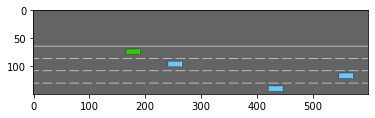

[[ 1.0000000e+00  1.0000000e+00  0.0000000e+00  2.5000000e-01
   0.0000000e+00]
 [ 1.0000000e+00  6.8833396e-02  2.5000000e-01  7.0612566e-03
  -8.9905861e-13]
 [ 1.0000000e+00  2.3250300e-01  7.5000000e-01  4.4244486e-03
   3.1308289e-14]
 [ 1.0000000e+00  3.4639329e-01  5.0000000e-01  4.0024393e-03
  -3.0531133e-14]
 [ 1.0000000e+00  4.5982212e-01  0.0000000e+00  3.6420505e-03
   0.0000000e+00]]

Acción: SLOWER -> recommpensa: 0.6666666666666671
Nuevo estado:


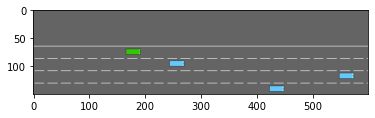

[[ 1.0000000e+00  1.0000000e+00  0.0000000e+00  2.5000000e-01
   0.0000000e+00]
 [ 1.0000000e+00  7.1665905e-02  2.5000000e-01  7.1040373e-03
  -7.2830630e-14]
 [ 1.0000000e+00  2.3417255e-01  7.5000000e-01  3.8984434e-03
  -4.7739590e-15]
 [ 1.0000000e+00  3.4812409e-01  5.0000000e-01  4.6805553e-03
   2.6201263e-14]
 [ 1.0000000e+00  4.6130610e-01  0.0000000e+00  3.7875832e-03
   0.0000000e+00]]

Acción: SLOWER -> recommpensa: 0.6666666666666671
Nuevo estado:


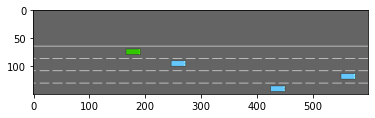

[[ 1.0000000e+00  1.0000000e+00  0.0000000e+00  2.5000000e-01
   0.0000000e+00]
 [ 1.0000000e+00  7.4515410e-02  2.5000000e-01  7.1462132e-03
   4.3076653e-14]
 [ 1.0000000e+00  2.3564278e-01  7.5000000e-01  3.4306701e-03
  -1.5543122e-15]
 [ 1.0000000e+00  3.5010919e-01  5.0000000e-01  5.2716504e-03
   1.9984014e-15]
 [ 1.0000000e+00  4.6284837e-01  0.0000000e+00  3.9335731e-03
   0.0000000e+00]]

Acción: SLOWER -> recommpensa: 0.6666666666666671
Nuevo estado:


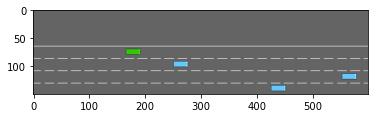

[[ 1.0000000e+00  1.0000000e+00  0.0000000e+00  2.5000000e-01
   0.0000000e+00]
 [ 1.0000000e+00  7.7381685e-02  2.5000000e-01  7.1878424e-03
   4.4408921e-15]
 [ 1.0000000e+00  2.3693600e-01  7.5000000e-01  3.0164630e-03
   2.2204460e-16]
 [ 1.0000000e+00  3.5231736e-01  5.0000000e-01  5.7937587e-03
  -1.2212453e-15]
 [ 1.0000000e+00  4.6444905e-01  0.0000000e+00  4.0794564e-03
   0.0000000e+00]]

Acción: SLOWER -> recommpensa: 0.6666666666666671
Nuevo estado:


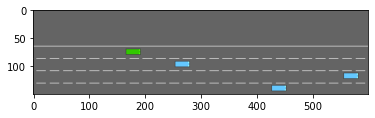

[[ 1.0000000e+00  1.0000000e+00  0.0000000e+00  2.5000000e-01
   0.0000000e+00]
 [ 1.0000000e+00  8.0264516e-02  2.5000000e-01  7.2289477e-03
  -1.9984014e-15]
 [ 1.0000000e+00  2.3807298e-01  7.5000000e-01  2.6520309e-03
   2.2204460e-16]
 [ 1.0000000e+00  3.5472363e-01  5.0000000e-01  6.2605948e-03
  -2.2204460e-16]
 [ 1.0000000e+00  4.6610796e-01  0.0000000e+00  4.2247511e-03
   0.0000000e+00]]

Acción: SLOWER -> recommpensa: 0.6666666666666671
Nuevo estado:


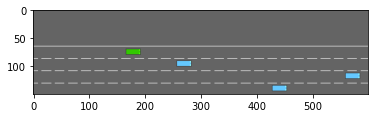

[[ 1.0000000e+00  1.0000000e+00  0.0000000e+00  2.5000000e-01
   0.0000000e+00]
 [ 1.0000000e+00  8.3163686e-02  2.5000000e-01  7.2695375e-03
  -3.3306691e-16]
 [ 1.0000000e+00  2.3907293e-01  7.5000000e-01  2.3340662e-03
   2.2204460e-16]
 [ 1.0000000e+00  3.5730797e-01  5.0000000e-01  6.6824364e-03
   0.0000000e+00]
 [ 1.0000000e+00  4.6782485e-01  0.0000000e+00  4.3690405e-03
   0.0000000e+00]]

Acción: SLOWER -> recommpensa: 0.6666666666666671
Nuevo estado:


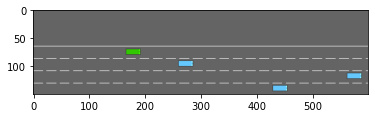

[[1.0000000e+00 1.0000000e+00 0.0000000e+00 2.5000000e-01 0.0000000e+00]
 [1.0000000e+00 8.6079001e-02 2.5000000e-01 7.3096147e-03 0.0000000e+00]
 [1.0000000e+00 2.3995392e-01 7.5000000e-01 2.0595097e-03 2.2204460e-16]
 [1.0000000e+00 3.6005387e-01 5.0000000e-01 7.0669656e-03 0.0000000e+00]
 [1.0000000e+00 4.6959919e-01 0.0000000e+00 4.5119664e-03 0.0000000e+00]]

Acción: SLOWER -> recommpensa: 0.6666666666666671
Nuevo estado:


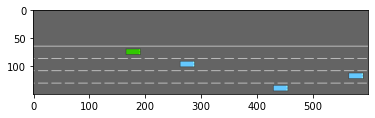

[[1.0000000e+00 1.0000000e+00 0.0000000e+00 2.5000000e-01 0.0000000e+00]
 [1.0000000e+00 8.9010246e-02 2.5000000e-01 7.3491777e-03 0.0000000e+00]
 [1.0000000e+00 2.4073274e-01 7.5000000e-01 1.8254215e-03 2.2204460e-16]
 [1.0000000e+00 3.6294752e-01 5.0000000e-01 7.4199629e-03 0.0000000e+00]
 [1.0000000e+00 4.7143039e-01 0.0000000e+00 4.6532205e-03 0.0000000e+00]]

Acción: SLOWER -> recommpensa: 0.6666666666666671
Nuevo estado:


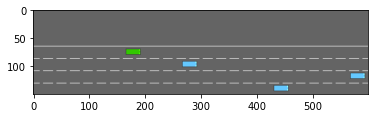

[[1.0000000e+00 1.0000000e+00 0.0000000e+00 2.5000000e-01 0.0000000e+00]
 [1.0000000e+00 9.1957226e-02 2.5000000e-01 7.3882220e-03 0.0000000e+00]
 [1.0000000e+00 2.4142502e-01 7.5000000e-01 1.6289246e-03 2.2204460e-16]
 [1.0000000e+00 3.6597717e-01 5.0000000e-01 7.7458317e-03 0.0000000e+00]
 [1.0000000e+00 4.7331777e-01 0.0000000e+00 4.7925399e-03 0.0000000e+00]]

Acción: SLOWER -> recommpensa: 0.6666666666666671
Nuevo estado:


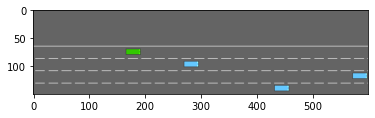

[[1.0000000e+00 1.0000000e+00 0.0000000e+00 2.5000000e-01 0.0000000e+00]
 [1.0000000e+00 9.4919719e-02 2.5000000e-01 7.4267415e-03 0.0000000e+00]
 [1.0000000e+00 2.4204530e-01 7.5000000e-01 1.4671881e-03 2.2204460e-16]
 [1.0000000e+00 3.6913264e-01 5.0000000e-01 8.0479877e-03 0.0000000e+00]
 [1.0000000e+00 4.7526047e-01 0.0000000e+00 4.9297009e-03 0.0000000e+00]]

Acción: SLOWER -> recommpensa: 0.6666666666666671
Nuevo estado:


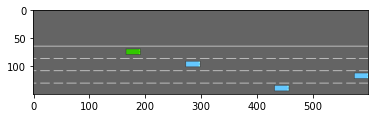

[[1.0000000e+00 1.0000000e+00 0.0000000e+00 2.5000000e-01 0.0000000e+00]
 [1.0000000e+00 9.7897530e-02 2.5000000e-01 7.4647279e-03 0.0000000e+00]
 [1.0000000e+00 2.4260694e-01 7.5000000e-01 1.3374352e-03 2.2204460e-16]
 [1.0000000e+00 3.7240496e-01 5.0000000e-01 8.3291326e-03 0.0000000e+00]
 [1.0000000e+00 4.7725758e-01 0.0000000e+00 5.0645149e-03 0.0000000e+00]]

Acción: SLOWER -> recommpensa: 0.6666666666666671
Nuevo estado:


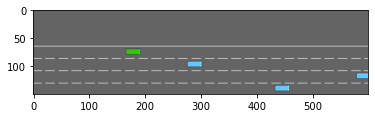

[[1.0000000e+00 1.0000000e+00 0.0000000e+00 2.5000000e-01 0.0000000e+00]
 [1.0000000e+00 1.0089043e-01 2.5000000e-01 7.5021717e-03 0.0000000e+00]
 [1.0000000e+00 2.4312223e-01 7.5000000e-01 1.2369603e-03 2.2204460e-16]
 [1.0000000e+00 3.7578619e-01 5.0000000e-01 8.5914508e-03 0.0000000e+00]
 [1.0000000e+00 4.7930819e-01 0.0000000e+00 5.1968270e-03 0.0000000e+00]]

Acción: SLOWER -> recommpensa: 0.6666666666666671
Nuevo estado:


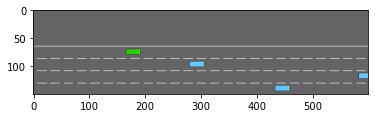

[[1.0000000e+00 1.0000000e+00 0.0000000e+00 2.5000000e-01 0.0000000e+00]
 [1.0000000e+00 1.0389820e-01 2.5000000e-01 7.5390618e-03 0.0000000e+00]
 [1.0000000e+00 2.4360240e-01 7.5000000e-01 1.1631497e-03 2.2204460e-16]
 [1.0000000e+00 3.7926909e-01 5.0000000e-01 8.8367416e-03 0.0000000e+00]
 [1.0000000e+00 4.8141122e-01 0.0000000e+00 5.3265081e-03 0.0000000e+00]]

Acción: SLOWER -> recommpensa: 0.6666666666666671
Nuevo estado:


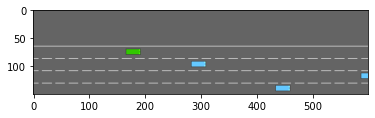

[[1.0000000e+00 1.0000000e+00 0.0000000e+00 2.5000000e-01 0.0000000e+00]
 [1.0000000e+00 1.0692062e-01 2.5000000e-01 7.5753881e-03 0.0000000e+00]
 [1.0000000e+00 2.4405763e-01 7.5000000e-01 1.1135010e-03 2.2204460e-16]
 [1.0000000e+00 3.8284716e-01 5.0000000e-01 9.0665175e-03 0.0000000e+00]
 [1.0000000e+00 4.8356560e-01 0.0000000e+00 5.4534557e-03 0.0000000e+00]]

Acción: SLOWER -> recommpensa: 0.6666666666666671
Nuevo estado:


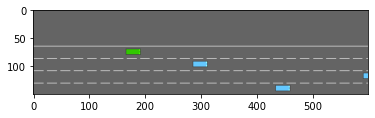

[[1.0000000e+00 1.0000000e+00 0.0000000e+00 2.5000000e-01 0.0000000e+00]
 [1.0000000e+00 1.0995747e-01 2.5000000e-01 7.6111387e-03 0.0000000e+00]
 [1.0000000e+00 2.4449714e-01 7.5000000e-01 1.0856388e-03 2.2204460e-16]
 [1.0000000e+00 3.8651446e-01 5.0000000e-01 9.2820693e-03 0.0000000e+00]
 [1.0000000e+00 4.8577026e-01 0.0000000e+00 5.5775894e-03 0.0000000e+00]]

Acción: SLOWER -> recommpensa: 0.6666666666666671
Nuevo estado:


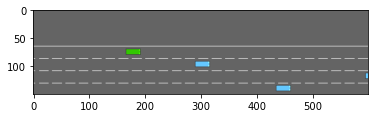

[[1.0000000e+00 1.0000000e+00 0.0000000e+00 2.5000000e-01 0.0000000e+00]
 [1.0000000e+00 1.1300851e-01 2.5000000e-01 7.6463041e-03 0.0000000e+00]
 [1.0000000e+00 2.4492922e-01 7.5000000e-01 1.0773264e-03 2.2204460e-16]
 [1.0000000e+00 3.9026549e-01 5.0000000e-01 9.4845127e-03 0.0000000e+00]
 [1.0000000e+00 4.8802403e-01 0.0000000e+00 5.6988490e-03 0.0000000e+00]]

Acción: SLOWER -> recommpensa: 0.6666666666666671
Nuevo estado:


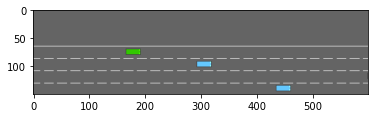

[[1.00000000e+00 1.00000000e+00 0.00000000e+00 2.50000000e-01
  0.00000000e+00]
 [1.00000000e+00 1.16073504e-01 2.50000000e-01 7.68087385e-03
  0.00000000e+00]
 [1.00000000e+00 2.45361313e-01 7.50000000e-01 1.08647323e-03
  2.22044605e-16]
 [1.00000000e+00 3.94095212e-01 5.00000000e-01 9.67482571e-03
  0.00000000e+00]
 [1.00000000e+00 4.90325749e-01 0.00000000e+00 5.81719074e-03
  0.00000000e+00]]

Acción: SLOWER -> recommpensa: 0.6666666666666671
Nuevo estado:


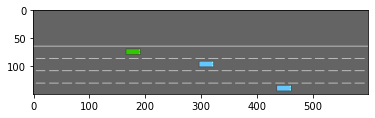

[[1.0000000e+00 1.0000000e+00 0.0000000e+00 2.5000000e-01 0.0000000e+00]
 [1.0000000e+00 1.1915222e-01 2.5000000e-01 7.7148397e-03 0.0000000e+00]
 [1.0000000e+00 2.4580003e-01 7.5000000e-01 1.1111386e-03 2.2204460e-16]
 [1.0000000e+00 3.9799893e-01 5.0000000e-01 9.8538725e-03 0.0000000e+00]
 [1.0000000e+00 4.9267426e-01 0.0000000e+00 5.9325867e-03 0.0000000e+00]]

Acción: SLOWER -> recommpensa: 0.6666666666666671
Nuevo estado:


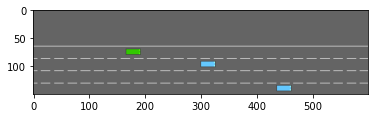

[[1.00000000e+00 1.00000000e+00 0.00000000e+00 2.50000000e-01
  0.00000000e+00]
 [1.00000000e+00 1.22244395e-01 2.50000000e-01 7.74819311e-03
  0.00000000e+00]
 [1.00000000e+00 2.46251225e-01 7.50000000e-01 1.14953122e-03
  2.22044605e-16]
 [1.00000000e+00 4.01972294e-01 5.00000000e-01 1.00224214e-02
  0.00000000e+00]
 [1.00000000e+00 4.95068371e-01 0.00000000e+00 6.04502158e-03
  0.00000000e+00]]

Acción: SLOWER -> recommpensa: 0.6666666666666671
Nuevo estado:


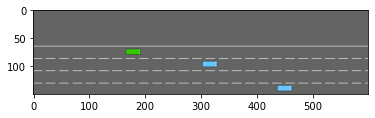

[[1.0000000e+00 1.0000000e+00 0.0000000e+00 2.5000000e-01 0.0000000e+00]
 [1.0000000e+00 1.2534980e-01 2.5000000e-01 7.7809286e-03 0.0000000e+00]
 [1.0000000e+00 2.4672008e-01 7.5000000e-01 1.2000069e-03 2.2204460e-16]
 [1.0000000e+00 4.0601119e-01 5.0000000e-01 1.0181161e-02 0.0000000e+00]
 [1.0000000e+00 4.9750692e-01 0.0000000e+00 6.1544930e-03 0.0000000e+00]]

Acción: SLOWER -> recommpensa: 0.6666666666666671
Nuevo estado:


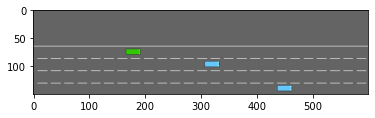

[[1.00000000e+00 1.00000000e+00 0.00000000e+00 2.50000000e-01
  0.00000000e+00]
 [1.00000000e+00 1.28468186e-01 2.50000000e-01 7.81304110e-03
  0.00000000e+00]
 [1.00000000e+00 2.47211158e-01 7.50000000e-01 1.26106397e-03
  2.22044605e-16]
 [1.00000000e+00 4.10111874e-01 5.00000000e-01 1.03307115e-02
  0.00000000e+00]
 [1.00000000e+00 4.99988705e-01 0.00000000e+00 6.26100693e-03
  0.00000000e+00]]

Acción: SLOWER -> recommpensa: 0.6666666666666671
Nuevo estado:


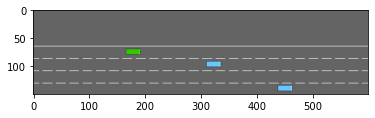

[[1.0000000e+00 1.0000000e+00 0.0000000e+00 2.5000000e-01 0.0000000e+00]
 [1.0000000e+00 1.3159931e-01 2.5000000e-01 7.8445263e-03 0.0000000e+00]
 [1.0000000e+00 2.4772841e-01 7.5000000e-01 1.3313368e-03 2.2204460e-16]
 [1.0000000e+00 4.1427073e-01 5.0000000e-01 1.0471634e-02 0.0000000e+00]
 [1.0000000e+00 5.0251251e-01 0.0000000e+00 6.3645798e-03 0.0000000e+00]]
Episodio terminado después de 40 pasos y la recompensa fue 26.694148001393476


In [48]:
# Carga del modelo entrenado
modelo = torch.load("DQN.pth")['state_dic']
dqn.load_state_dict(modelo)

obs = env.reset()
t, total_reward, done = 0, 0, False

print("Obs inicial:")
plt.imshow(env.render(mode="rgb_array"))
plt.show()
print(obs)

while not done:
    # Obtener la acción y la ejecutamos
    action = dqn.get_action(obs, 0)
    new_obs, reward, done, info = env.step(action)
    
    # Imprimimos el paso
    print("\nAcción: {} -> recommpensa: {}".format(env.action_type.actions[action], reward))
    print("Nuevo estado:")
    plt.imshow(env.render(mode="rgb_array"))
    plt.show()
    env.close()
    print(new_obs)
    
    t += 1
    total_reward += reward
    obs = new_obs
    
print("Episodio terminado después de {} pasos y la recompensa fue {}".format(t, total_reward))